- Giovana Rodrigues - 02211023
- Erik Pacheco - 02211013
- Enzo Godoy - 02211012
- Lucas Mesquita - 02211044

#### Libs

In [18]:
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.svm import SVC
import joblib
from sklearn.preprocessing import MinMaxScaler

In [19]:
# Aplica o seed para todo o documento
np.random.seed(42)

#### Pré-processamento de dados

> CARREGANDO OS DADOS

- https://complex-valued-neural-networks.readthedocs.io/en/stable/code_examples/fashion_mnist.html

In [20]:
# Carregando o Fashion MNIST dataset
fashion_mnist = fetch_openml('Fashion-MNIST', version=1, cache=True, as_frame=False)

In [21]:
# Extrair as imagens e os rótulos
X = np.array(fashion_mnist['data'])
y = np.array(fashion_mnist['target'])

> VISUALIZANDO AS IMAGENS DO MNIST

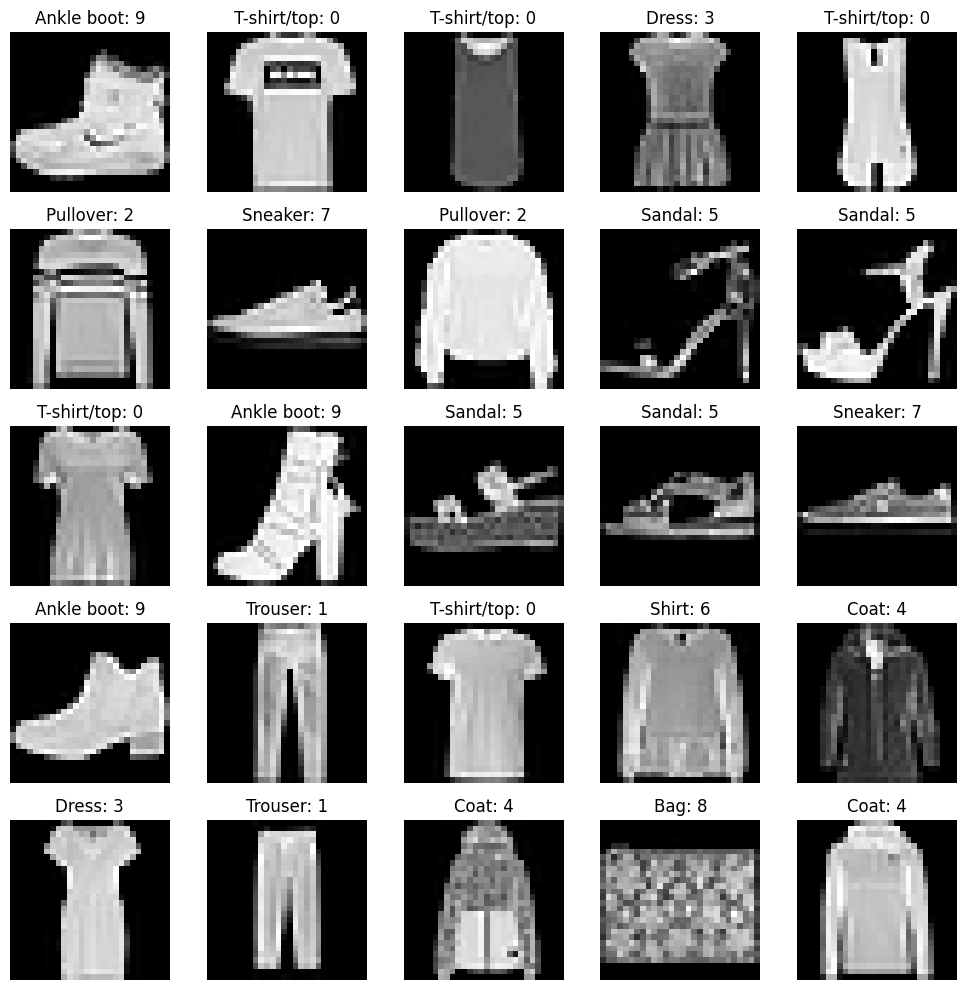

In [22]:
# As classes foram tiradas da documentação oficial
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Função para plotar algumas imagens
def plot_images(images, labels, n_cols=5):
    n_rows = len(images) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*2, n_rows*2))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].reshape(28, 28), cmap='gray')
        ax.set_title(f'{class_names[int(labels[i])]}: {labels[i]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

# Visualizar as primeiras 25 imagens
plot_images(X[:25], y[:25])

> FAZENDO O PRÉ PROCESSAMENTO DOS DADOS

**Por que foi feito:**

Normalização: Inicialmente, os dados são normalizados usando StandardScaler para garantir que cada feature tenha média zero e variância unitária. Isso é essencial para algoritmos como PCA, que são sensíveis à escala dos dados.

Redução de Dimensionalidade com PCA: PCA é aplicado após a normalização para reduzir a dimensionalidade dos dados. Reduzir a dimensionalidade pode melhorar a eficiência computacional e ajudar a evitar o problema de alta dimensionalidade, onde os dados podem tornar-se dispersos ou esparsos.

Divisão dos Dados: A divisão dos dados em conjuntos de treinamento e teste é feita para avaliar o desempenho do modelo em dados não vistos durante o treinamento. O tamanho do conjunto de teste é fixado em 20% do total, uma escolha comum para evitar overfitting.

Conversão de Rótulos: A conversão de rótulos de string para inteiros é necessária para compatibilidade com os modelos de machine learning, que esperam rótulos numéricos.

Essas etapas de pré-processamento são fundamentais para preparar os dados antes de treinar qualquer modelo de machine learning. Cada escolha feita visa melhorar a eficiência, precisão e interpretabilidade do modelo final.

> Normalizar os dados

In [23]:
X.astype(np.float64)

# Configurar o MinMaxScaler para o intervalo [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))

# Redimensionar os dados para duas dimensões (necessário para o MinMaxScaler)
X_reshaped = X.reshape(-1, X.shape[-1])

# Ajustar e transformar os dados de treinamento
X_n = scaler.fit_transform(X_reshaped).reshape(X.shape)


In [24]:
print(X_n[0])

[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.00392157 0.         0.         0.05098039 0.28627451 

In [25]:
# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_n, y, test_size=0.2)

print(f"Formato dos dados de treino normalizados: {X_train.shape}")
print(f"Formato dos dados de teste normalizados: {X_test.shape}")

Formato dos dados de treino normalizados: (56000, 784)
Formato dos dados de teste normalizados: (14000, 784)


> Aplicar PCA para saber qual o número de componentes se encaixaria

In [56]:
pca = PCA(50)
X_train_pca_c = pca.fit_transform(X_train)
X_test_pca_c = pca.transform(X_test)


> Plotar o gráfico do cotovelo

In [57]:
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

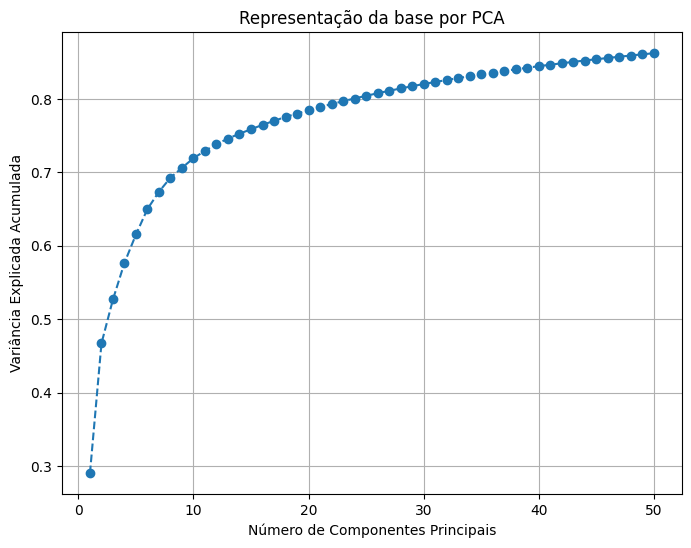

In [58]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='--')
plt.title('Representação da base por PCA')
plt.xlabel('Número de Componentes Principais')
plt.ylabel('Variância Explicada Acumulada')
plt.grid(True)
plt.show()

In [59]:
# Aplicar PCA para reduzir a dimensionalidade
pca = PCA(n_components=25)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

> FAZENDO ANALISE DA DISTRIBUIÇÃO DOS ROTULOS

In [60]:
# Converter rótulos para inteiro
y_train_int = y_train.astype(int)
y_test_int = y_test.astype(int)

#### Modelagem

## KNN

Melhor valor de k: 6 com uma acurácia de 0.8447


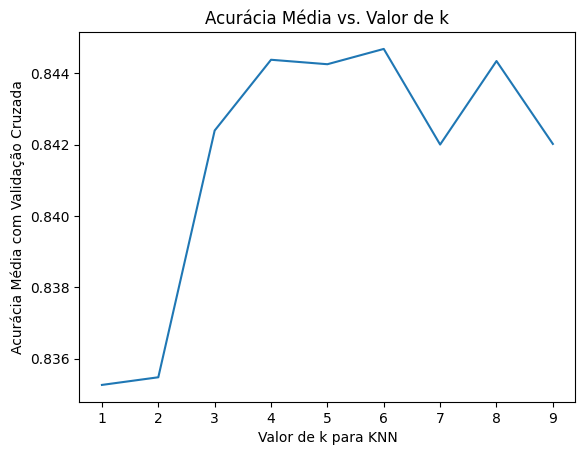

In [31]:
# Definir a faixa de valores de k que queremos testar
k_range = range(1, 10)
k_scores = []

# Utilizar validação cruzada para cada valor de k
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    # Aqui usamos 2-fold cross-validation
    scores = cross_val_score(knn, X_train, y_train, cv=2, scoring='accuracy')
    k_scores.append(scores.mean())

# Encontrar o valor de k com a melhor acurácia
best_k = k_range[np.argmax(k_scores)]
best_score = max(k_scores)

print(f"Melhor valor de k: {best_k} com uma acurácia de {best_score:.4f}")

# Plotar os resultados
import matplotlib.pyplot as plt

plt.plot(k_range, k_scores)
plt.xlabel('Valor de k para KNN')
plt.ylabel('Acurácia Média com Validação Cruzada')
plt.title('Acurácia Média vs. Valor de k')
plt.show()

In [61]:
# Treinar o modelo KNN
knn = KNeighborsClassifier(n_neighbors=6)
knn.fit(X_train_pca, y_train_int)

# Avaliar o modelo no conjunto de teste
y_test_int_pred = knn.predict(X_test_pca)
test_accuracy = accuracy_score(y_test_int, y_test_int_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Mostrar relatório de classificação
print(classification_report(y_test_int, y_test_int_pred))

Test Accuracy: 0.8536
              precision    recall  f1-score   support

           0       0.76      0.87      0.81      1394
           1       0.98      0.97      0.97      1402
           2       0.75      0.79      0.77      1407
           3       0.89      0.87      0.88      1449
           4       0.75      0.77      0.76      1357
           5       0.95      0.90      0.93      1449
           6       0.68      0.54      0.60      1407
           7       0.89      0.94      0.91      1359
           8       0.96      0.95      0.96      1342
           9       0.92      0.94      0.93      1434

    accuracy                           0.85     14000
   macro avg       0.85      0.85      0.85     14000
weighted avg       0.85      0.85      0.85     14000



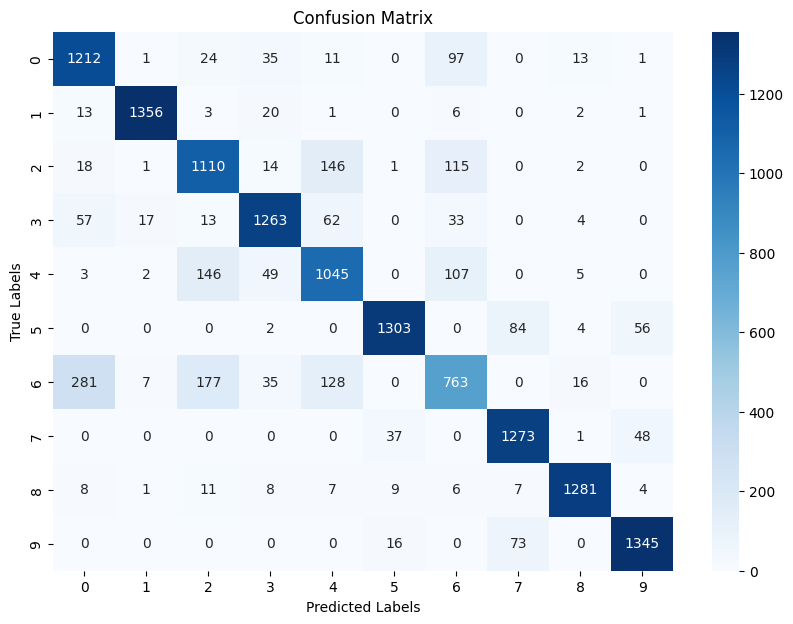

In [62]:
conf_matrix = confusion_matrix(y_test_int, y_test_int_pred)

# Plotar a matriz de confusão
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

## Decision Tree with Grid

In [34]:
dt = DecisionTreeClassifier()

In [35]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

In [36]:
grid_search = GridSearchCV(estimator=dt, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

In [37]:
grid_search.fit(X_train_pca, y_train_int)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 10, 20, 30, 40, 50],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]},
             verbose=2)

In [38]:
best_model = grid_search.best_estimator_
print(f'Melhores hiperparâmetros: {grid_search.best_params_}')

Melhores hiperparâmetros: {'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 4, 'min_samples_split': 10}


In [39]:
y_pred = best_model.predict(X_test_pca)

In [40]:
accuracy = accuracy_score(y_test_int, y_pred)
print(f'Acurácia no conjunto de teste: {accuracy:.2f}')

Acurácia no conjunto de teste: 0.78


In [41]:
report = classification_report(y_test_int, y_pred, target_names=class_names)
print(f'Relatório de classificação:\n{report}')

Relatório de classificação:
              precision    recall  f1-score   support

 T-shirt/top       0.71      0.74      0.72      1394
     Trouser       0.94      0.94      0.94      1402
    Pullover       0.65      0.69      0.67      1407
       Dress       0.80      0.80      0.80      1449
        Coat       0.67      0.66      0.66      1357
      Sandal       0.86      0.87      0.86      1449
       Shirt       0.53      0.49      0.51      1407
     Sneaker       0.84      0.85      0.84      1359
         Bag       0.92      0.89      0.90      1342
  Ankle boot       0.90      0.89      0.89      1434

    accuracy                           0.78     14000
   macro avg       0.78      0.78      0.78     14000
weighted avg       0.78      0.78      0.78     14000



In [42]:
conf_matrix = confusion_matrix(y_test_int, y_pred)

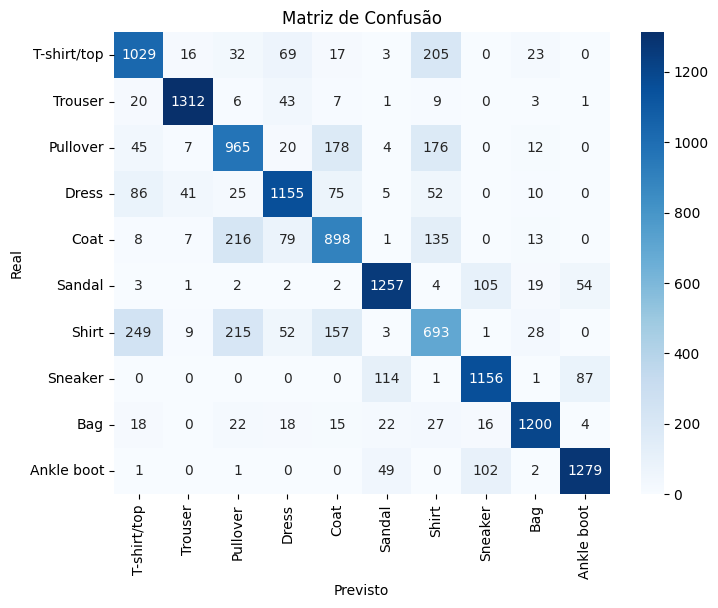

In [43]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.ylabel('Real')
plt.xlabel('Previsto')
plt.title('Matriz de Confusão')
plt.show()

## SVC

In [63]:
# Treinar o modelo SVC
svc = SVC(random_state=42)
svc.fit(X_train_pca, y_train_int)

# Avaliar o desempenho inicial
y_pred_initial = svc.predict(X_test_pca)
initial_accuracy = accuracy_score(y_test_int, y_pred_initial)
print(f'Acurácia inicial do modelo SVC: {initial_accuracy:.4f}')

# Mostrar o relatório de classificação
print("Classification Report (Modelo Inicial):")
print(classification_report(y_test_int, y_pred_initial))

Acurácia inicial do modelo SVC: 0.8668
Classification Report (Modelo Inicial):
              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1394
           1       0.99      0.96      0.97      1402
           2       0.80      0.78      0.79      1407
           3       0.86      0.88      0.87      1449
           4       0.77      0.81      0.79      1357
           5       0.95      0.93      0.94      1449
           6       0.68      0.61      0.64      1407
           7       0.90      0.93      0.92      1359
           8       0.96      0.97      0.96      1342
           9       0.95      0.94      0.95      1434

    accuracy                           0.87     14000
   macro avg       0.87      0.87      0.87     14000
weighted avg       0.87      0.87      0.87     14000



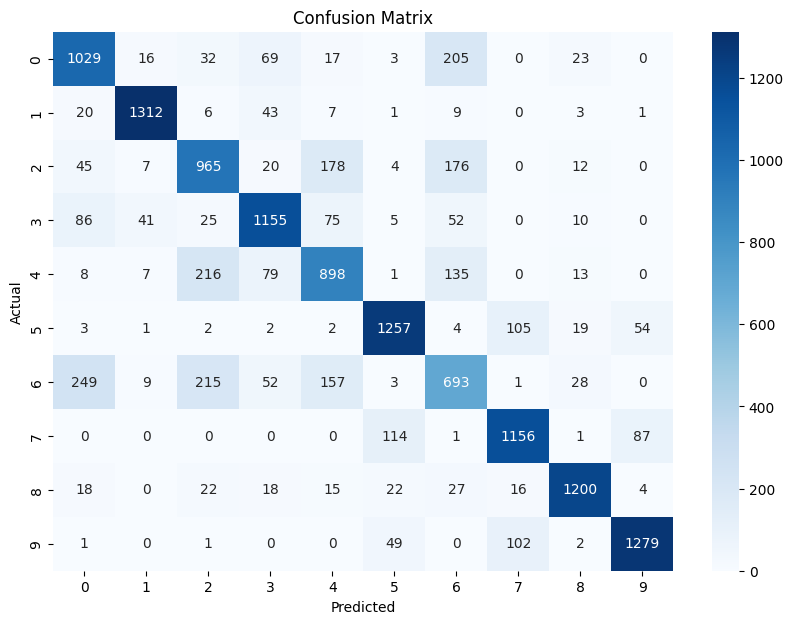

In [48]:
# Plotar a matriz de confusão usando seaborn
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Comparação entre os modelos

|Nome do Modelo | Accuracy(%) | Precision | Recall | F1 | Tempo de execução (segundos)|
|---------------|-------------|-----------|--------|----|-----------------------------|
| Decision Tree | 0.78 | 0.78 | 0.78 | 0.78 | 490 |
| KNN | 0.85 | 0.85 | 0.85 | 0.85 | 1.5 |
| Random Forest | ? | ? | ? | ? | 19.400 |
| SVC | 86 | 87 | 87 | 87 | 100 |

SVC parece ser o melhor modelo em termos de precisão, recall e F1-score, com um tempo de execução razoável.

KNN oferece um bom desempenho com tempo de execução muito baixo, tornando-o uma escolha adequada para situações onde o tempo de treinamento é crítico.

Decision Tree é menos preciso e mais lento que KNN e SVC, mas ainda pode ser útil dependendo da simplicidade do modelo ou da interpretabilidade.

Random Forest precisa ser avaliado quanto à precisão, recall e F1-score para uma conclusão completa, mas seu alto tempo de execução é uma desvantagem significativa.

Dependendo das prioridades (desempenho de classificação vs. tempo de execução), o KNN e o SVC são modelos promissores, com o SVC tendo uma ligeira vantagem em precisão.

## Salvar Modelo

In [46]:
joblib.dump(knn, './modelo_knn_grupo_9_e_Giovana.pkl')

['./modelo_knn_grupo_9_e_Giovana.pkl']